In [1]:
#import
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
plt.style.use('fivethirtyeight')

C:\Users\XXXXX\Anaconda3\envs\Python\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [2]:
#Configure
#customend = None
#date1 = enddate1 if customend != '':, else customend

#Length of training
train_ran = 8000 #how much data to give to the model to eat up in days
train_range = int(train_ran) 
train_range2 = 120 #secondary data testing
numofepochs = 3 #number of iterations
batchsize = 7 #how many prices it takes at a time
startdate1 = "1980-01-01"
enddate1 = date.today()
source1 = "yahoo"
stonk = "^GSPC"
#Get the stock quote
df = web.DataReader(stonk, data_source=source1, start=startdate1, end=enddate1)
#show
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-01-02,108.430000,105.290001,107.940002,105.760002,40610000,105.760002
1980-01-03,106.080002,103.260002,105.760002,105.220001,50480000,105.220001
1980-01-04,107.080002,105.089996,105.220001,106.519997,39130000,106.519997
1980-01-07,107.800003,105.800003,106.519997,106.809998,44500000,106.809998
1980-01-08,109.290001,106.290001,106.809998,108.949997,53390000,108.949997
...,...,...,...,...,...,...
2020-02-26,3182.510010,3108.989990,3139.899902,3116.389893,5478110000,3116.389893
2020-02-27,3097.070068,2977.389893,3062.540039,2978.760010,7058840000,2978.760010
2020-02-28,2959.719971,2855.840088,2916.899902,2954.219971,8563850000,2954.219971


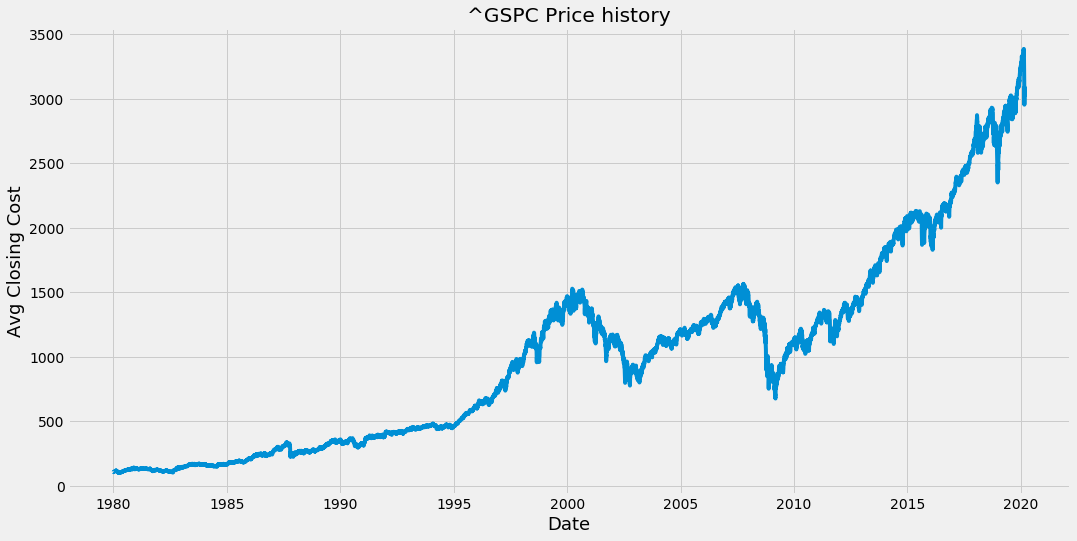

In [3]:
#Get x by y of the dataset
df.shape
#Plot that bitch
plt.figure(figsize=(16,8))
plt.title('{} Price history'.format(stonk))
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Avg Closing Cost', fontsize=18)
plt.show()

In [4]:
#Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on
training_data_len = math.ceil( len(dataset) * .8 )
training_data_len

8104

In [5]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00229324],
       [0.002129  ],
       [0.00252438],
       ...,
       [0.86863165],
       [0.9099981 ],
       [0.88750372]])

In [6]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len , :]
train_rangeplus = int(train_range) + 1
print (train_rangeplus)
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(train_range, len(train_data)):
  x_train.append(train_data[i-train_range:i, 0])
  y_train.append(train_data[i, 0])
  if i<= train_rangeplus:
    print(x_train)
    print(y_train)
    print()

8001
[array([0.00229324, 0.002129  , 0.00252438, ..., 0.32362309, 0.32684699,
       0.33165551])]
[0.33786912055254475]

[array([0.00229324, 0.002129  , 0.00252438, ..., 0.32362309, 0.32684699,
       0.33165551]), array([0.002129  , 0.00252438, 0.00261258, ..., 0.32684699, 0.33165551,
       0.33786912])]
[0.33786912055254475, 0.33996771286490085]



In [7]:
#Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

In [8]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(104, 8000, 1)

In [9]:
#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [10]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
#Train the model
model.fit(x_train, y_train, batch_size=batchsize, epochs=numofepochs)

Epoch 1/3
104/104 [==============================] - 150s 1s/step - loss: 0.0220

In [17]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - train_range: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(train_range, len(test_data)):
  x_test.append(test_data[i-train_range:i, 0])

In [13]:
#Convert the data to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
#Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#Get the root mean squared error (RMSE)
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

518.5397368923988

C:\Users\Aydin\Anaconda3\envs\Python\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


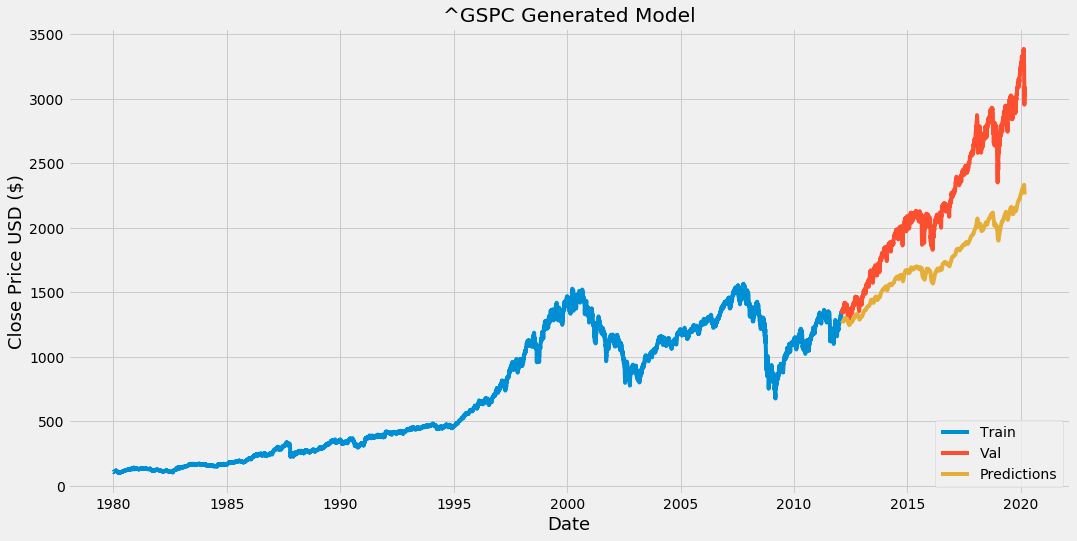

In [14]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('{} Generated Model'.format(stonk))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [15]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2012-02-14,1350.500000,1262.293701
2012-02-15,1343.229980,1263.690430
2012-02-16,1358.040039,1264.646729
2012-02-17,1361.229980,1265.811646
2012-02-21,1362.209961,1267.147217
...,...,...
2020-02-26,3116.389893,2320.717285
2020-02-27,2978.760010,2309.167480
2020-02-28,2954.219971,2292.515625


In [19]:
#Get quote
stonksquote = web.DataReader(stonk, data_source=source1, start=startdate1, end=enddate1)
#Create a new df
new_df = stonksquote.filter(['Close'])
#60 close -> Array
range_1 = new_df[-train_range:].values
#Scale
range_1scaled = scaler.transform(range_1)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(range_1scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[2243.0295]]


In [20]:
#Get the quote
stonksquote2 = web.DataReader(stonk, data_source=source1, start=startdate1, end=enddate1)
print(stonksquote2['Close'])



Date
1980-01-02     105.760002
1980-01-03     105.220001
1980-01-04     106.519997
1980-01-07     106.809998
1980-01-08     108.949997
                 ...     
2020-02-26    3116.389893
2020-02-27    2978.760010
2020-02-28    2954.219971
2020-03-02    3090.229980
2020-03-03    3009.860107
Name: Close, Length: 10129, dtype: float64
